# 0.0. Entender o Problema

-- Objetivo do Problema: 1.0. Previsao do primeiro destino que um usuário irá escolher

    -- Porque?
        -- Qual o tipo de modelo de negócio do Airbnb?
            -- Marketplace (Conectar pessoas que oferecem acomodações com pessoas que estão procurando acomodações)
            
            -- Oferta (pessoas oferecendo acomodações)
                -- Tamanho do portfólio
                -- Diversidade/Densidade do portfólio
                -- Preço Médio
            
            -- Demanda (pessoas procurando acomodações)
                -- Número de Usuários
                -- LTV (Lifetime Value)
                -- CAC (Cliente Acquisition Cost)
                
            -- Gross Revenue = (Fee*Numero cliente) - CAC
            
    -- Proposta de Solução
        -- Modelo de Previsão do primeiro destino de um novo usuário
        -- 1.0. Predições e salva em tabela de banco de dados
        -- 2.0 API
            -- Input: Usuário e Suas Características
            -- Output: Usuário e Suas características com a predição do destino.
            
       

# Ciclo 01: End to End

## 0.0 Imports

### 0.1 Helper Functions

In [50]:
import random
import pandas as pd
from sklearn import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import metrics as m
from scikitplot import metrics as mt
from keras  import models as ml
from keras import layers as l

### 0.2 Loading Data

In [20]:
!ls -s data_set

total 641120
616848 sessions.csv   24272 training_users.csv


In [21]:
df_raw = pd.read_csv('data_set/training_users.csv', low_memory = True)
df_raw.shape

(213451, 16)

In [22]:
#df_sessions = pd.read_csv('data_set/sessions.csv', low_memory=True)
#df_sessions.shape

#-- Preciso fazer uma granularidade do tipo Usuário/Seção ou só Usuário

#-- O número de usuários por granularidade

#df_sessions.sort_values('user_id').head()
#ordena por usuário e lista os primeiros

#df_sessions(df_sessions['user_id']=='00023iyk91')[['user_id','action']].groupby('user_id').count()

#Vai mostrar quantas ações foi feita pelo usuário.

#df_sessions(df_sessions['user_id']=='00023iyk91')[['user_id','action']].groupby('user_id').value_counts()
#conta quantas linhas eu tenho por usuário e por ação.

#Voltamos depois nesses dados.

## 1.0 Data Description

In [23]:
df1 = df_raw.copy()

In [24]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


#### 1.1 Data Type

In [25]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

#### 1.2 NA Check

In [26]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [27]:
# Removendo dados faltantes
df1 = df1.dropna()
df1.shape

(68171, 16)

#### 1.3 Change Data Type

In [28]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )


# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'],format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype(int)

#### 1.4 Check Balanced Data

In [29]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## 2.0. Data Filtering

In [30]:
df2 = df1.copy()

#### 2.1 Filtering Rows

#### 2.2 Columns Selection

## 3.0 Data Preparation

In [31]:
df3 = df2.copy()

In [32]:
# Dummy variable
df3_dummy = pd.get_dummies(df3.drop(['id', 'country_destination'], axis = 1))

#Join id and country destination
df3 = pd.concat([df3[['id', 'country_destination']], df3_dummy], axis = 1)

## 4.0 Feature Selection

In [33]:
cols_drop=['date_account_created', 'timestamp_first_active', 'date_first_booking'] #original dates
df4 = df3.drop(cols_drop, axis = 1)

In [34]:
df4.sample().T

,171864
id,guqqqqofhm
country_destination,US
age,39
signup_flow,0
gender_-unknown-,0
...,...
first_browser_Sogou Explorer,0
first_browser_Stainless,0
first_browser_TenFourFox,0
first_browser_TheWorld Browser,0


## 5.0 Machine Learning Model

In [35]:
X = df4.drop('country_destination', axis = 1)
y = df4['country_destination'].copy()

In [36]:
#Split dataset into training and test

X_train, X_test, y_train, y_test = ms.train_test_split (X,y, test_size = 0.2, random_state = 32)

In [37]:
x_train = X_train.drop('id', axis = 1)
x_test = X_test.drop('id', axis = 1)

## 5.1 Baseline Model

In [62]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

In [61]:
df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

[0.00636634345982896,
 0.01569582373736633,
 0.012453976030863564,
 0.024863945079285913,
 0.05408458142025201,
 0.02593478165202212,
 0.02976338912440774,
 0.008801396488242802,
 0.002317701075237271,
 0.7088644731630752,
 0.11085358876941809]

In [65]:
yhat_random = random.choices(population=country_destination_list, 
                             weights =country_destination_weights,k = k_num)
len(yhat_random)

13635

Accuracy: 0.521085441877521
Balanced Accuracy: 0.08984249599002934
Kappa Score:-0.0023346273189750466
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.02      0.02      0.02       214
          DE       0.01      0.01      0.01       170
          ES       0.04      0.04      0.04       345
          FR       0.05      0.06      0.06       710
          GB       0.01      0.01      0.01       344
          IT       0.03      0.02      0.02       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.10      0.10      0.10      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

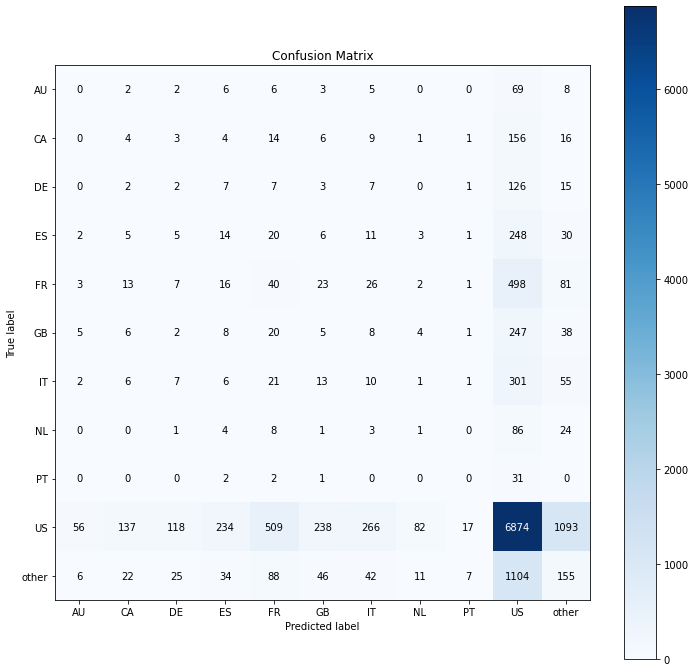

In [66]:
# accuracy
acc_random = m.accuracy_score(y_test_nn,yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test_nn,yhat_random)
print(f'Balanced Accuracy: {balanced_acc_random}')

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test_nn,yhat_random)
print(f'Kappa Score:{kappa_random}')

# Classification Report
print(m.classification_report(y_test_nn, yhat_random))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_random, normalize=False, figsize = (12,12))

## 5.2 Neural Network - MLP

In [38]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [39]:
x_train.shape

(54536, 112)

In [40]:
#Model Definition

model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(11, activation='softmax'))

#Model Compile
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x_train, y_train_nn, epochs = 100)

Epoch 1/100
1705/1705 [==============================] - 27s 3ms/step - loss: 1.4071 - accuracy: 0.6938
Epoch 2/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.2911 - accuracy: 0.7072
Epoch 3/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2537 - accuracy: 0.7071
Epoch 4/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2053 - accuracy: 0.7074
Epoch 5/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.2157 - accuracy: 0.7080
Epoch 6/100
1705/1705 [==============================] - 4s 2ms/step - loss: 1.1880 - accuracy: 0.7065
Epoch 7/100
1705/1705 [==============================] - 4s 3ms/step - loss: 1.1736 - accuracy: 0.7082
Epoch 8/100
1705/1705 [==============================] - 6s 3ms/step - loss: 1.1440 - accuracy: 0.7124
Epoch 9/100
1705/1705 [==============================] - 5s 3ms/step - loss: 1.1498 - accuracy: 0.7088
Epoch 10/100
1705/1705 [==============================] - 5s 3ms/step - 

1705/1705 [==============================] - 2s 1ms/step - loss: 1.0897 - accuracy: 0.7140
Epoch 80/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1001 - accuracy: 0.7111
Epoch 81/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0945 - accuracy: 0.7122
Epoch 82/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0920 - accuracy: 0.7145
Epoch 83/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0952 - accuracy: 0.7127
Epoch 84/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0932 - accuracy: 0.7134
Epoch 85/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0980 - accuracy: 0.7098
Epoch 86/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1014 - accuracy: 0.7107
Epoch 87/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0988 - accuracy: 0.7124
Epoch 88/100
1705/1705 [==============================] - 2s 1ms/step - loss:

## 6.0 NN Performance

In [41]:
# prediction
pred_nn = model.predict(x_test)

# invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()

yhat_nn = yhat_nn.reshape(1,-1)[0]

In [43]:
# Balanced Accuracy
m.balanced_accuracy_score(y_test_nn,yhat_nn)

0.09063041922937637

Accuracy: 0.7028969563623029
Balanced Accuracy: 0.09063041922937637
Kappa Score:-0.0014625584705192374


/home/caio/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caio/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/caio/.pyenv/versions/3.8.0/envs/airbnb_predict_first_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.07      0.00      0.00      1540

    accuracy                           0.70     13635
   macro avg       0.07      0.09      0.08     13635
weighted avg       0.51      0.70      0.58     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

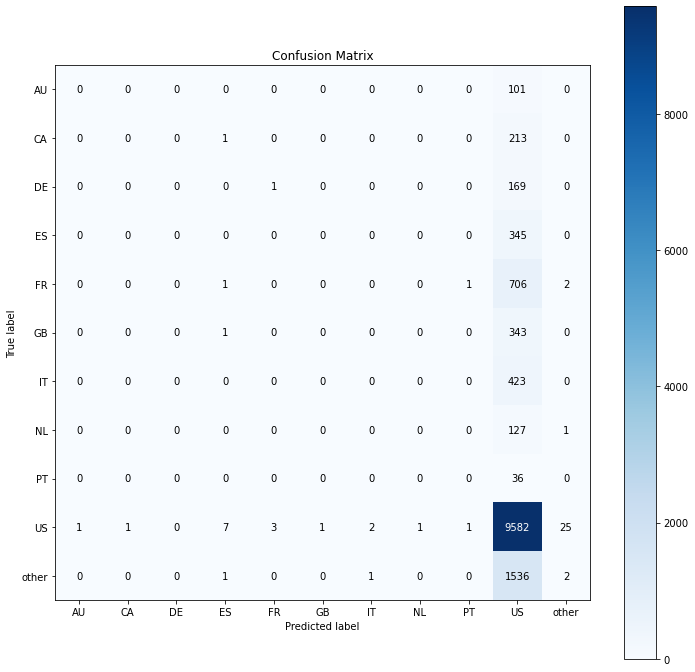

In [48]:
# accuracy
acc_nn = m.accuracy_score(y_test_nn,yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn,yhat_nn)
print(f'Balanced Accuracy: {balanced_acc_nn}')

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn,yhat_nn)
print(f'Kappa Score:{kappa_nn}')

# Classification Report
print(m.classification_report(y_test_nn, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize = (12,12))



# F-Score Balanced
# Recall-Precison
# ROC 
# Kappa Metrics
# Matthew Metrics